# Demonstrating Directed Acyclic Graphs (DAGs) with DoWhy

This notebook covers:
- Creating a DAG using DoWhy
- Simulating interventions
- Assessing DAG assumptions
- Plotting DAGs and intervention effects

In [51]:
import warnings
warnings.filterwarnings('ignore')

# Install required libraries (uncomment if running in a new environment)
!pip install dowhy matplotlib numpy pandas networkx pygraphviz

In [52]:
# Import required libraries
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Create a Directed Acyclic Graph (DAG) with DoWhy

Let's define a simple DAG representing relationships between variables using DoWhy.

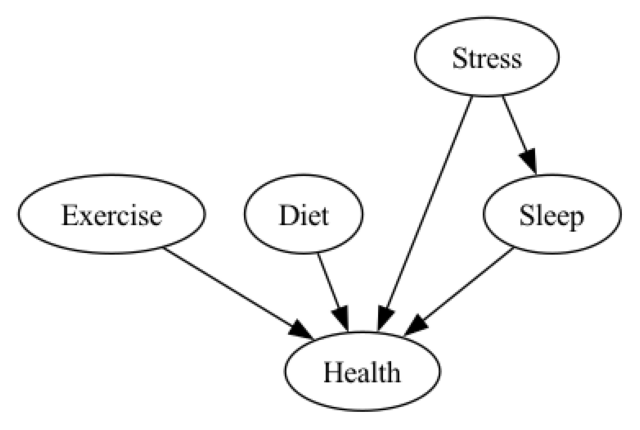

In [ ]:
# Simulate data for the DAG
np.random.seed(42)
data = pd.DataFrame({
    'Exercise': np.random.binomial(1, 0.5, 100),
    'Diet': np.random.binomial(1, 0.5, 100),
    'Sleep': np.random.binomial(1, 0.5, 100),
    'Stress': np.random.binomial(1, 0.5, 100)
})
data['Health'] = (data['Exercise']*0.8 + data['Diet']*0.6 + data['Sleep']*0.5 - data['Stress']*0.4 + np.random.normal(0, 0.1, 100))

# Define the DAG using a graph string
causal_graph = """
    digraph {
        Exercise -> Health;
        Diet -> Health;
        Sleep -> Health;
        Stress -> Sleep;
        Stress -> Health;
    }
"""

model = CausalModel(
    data=data,
    treatment="Exercise",
    outcome="Health",
    graph=causal_graph
)
model.view_model()

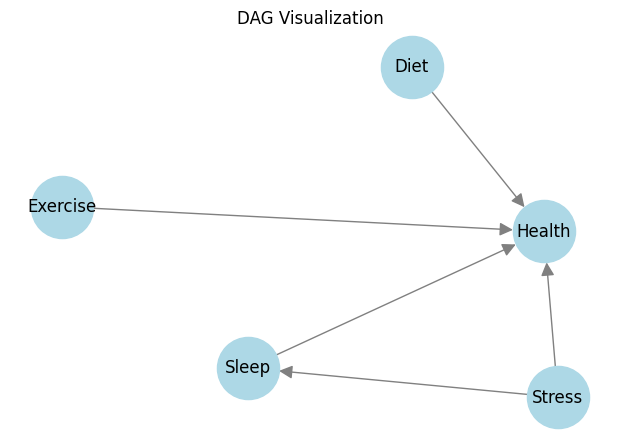

In [54]:
# Visualize the DAG using networkx and matplotlib
import networkx as nx

def plot_dag(graph_str):
    import re
    edges = re.findall(r'(\w+) -> (\w+);', graph_str)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(6,4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, arrowsize=20)
    plt.title('DAG Visualization')
    plt.show()

plot_dag(causal_graph)

## Simulate Interventions on the DAG

Let's simulate an intervention (do-operator) on one of the nodes and observe the effect on others using DoWhy.

In [55]:
# Identify and estimate the causal effect of Exercise on Health
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal effect of Exercise on Health:", estimate.value)

Causal effect of Exercise on Health: 0.8030531167351845


The result means that, according to your DAG and data, increasing Exercise by one unit is estimated to increase Health by about 0.80 units, holding other factors constant. This suggests a strong positive causal relationship: more exercise leads to better health in your simulated scenario.

## Assess DAG Assumptions

Let's check key assumptions such as conditional independence and refute the estimated effect using DoWhy.

In [56]:
# Refute the estimated effect using placebo test
refute_result = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print(refute_result)

Refute: Use a Placebo Treatment
Estimated effect:0.8030531167351845
New effect:-0.003747582757422325
p value:0.98



This result means your estimated causal effect (0.80) is likely not due to random chance or confounding. The placebo test replaced the treatment with a random variable, resulting in a near-zero effect (-0.0037) and a high p-value (0.98), indicating no significant relationship when the treatment is random. This supports the validity of your original causal estimate.